In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib
import os
import random
from matplotlib.lines import Line2D

# Matplotlib rc parameters modification

plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 8,
  "ytick.labelsize"         : 8,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5,
})
#plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'

colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

# reading rig files

# def rigList(rigFile):
#     hashCounter = -4
#     clusterIDs  = []
#     for line in rigFile:
#         if line[0] == '#':
#             hashCounter += 1
#         elif hashCounter >= 0:
#             clusterIDs.append(line.strip())
#     return clusterIDs
def rigList(rigFile):
    hashCounter = -4
    clusterIDs  = []
    temp = []
    for line in rigFile:
        if line[0] == '#':
            hashCounter += 1
            if len(temp) > 0:
                clusterIDs.append(temp)
                temp = []
        elif hashCounter >= 0:
            temp.append(line.strip())
            
    rigClusterIDsList = []
    for ii, sampleList in enumerate(clusterIDs):
        tempList = []
        for kk in range(len(sampleList)):
            tempList.append([int(indx) for indx in sampleList[kk].split(',')])
        rigClusterIDsList.append(tempList)
    return rigClusterIDsList

def particleSizeList(randomSeedFile, sizeRatio, npp = 1000):
    '''
    This function reads the random seed file and creates
    a list of particle sizes. The list index is the particle index.

    Inputs:
    randomSeedFile - location for the random seed file. It contains the particle index and sizes
    sizeRatio      - delta or ar for the case
    npp            - system size
    '''

    if sizeRatio == 1:
        # Painting particles randomly in two colours for monodisperse case.
        particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
        random.shuffle(particleSize)
    else:
        particleSize = np.loadtxt(randomSeedFile, usecols = 3) # reading only column 3 which has particle size
        randomSeedFile.close()
    return particleSize


def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

def parametersList(ParametersFile):
    '''
    This function reads the parameters file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: ParametersFile - the location of the parameters data file
    '''

    parFile = open(ParametersFile, 'r')

    hashCounter = 0
    temp        = []
    parList     = [] # list with parameters parameters for each element at each timestep

    fileLines = parFile.readlines()[22:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                parList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    parFile.close()
    return parList

Current x-axis limits: (0.855350553505535, 0.9798277982779829)


<Figure size 640x480 with 0 Axes>

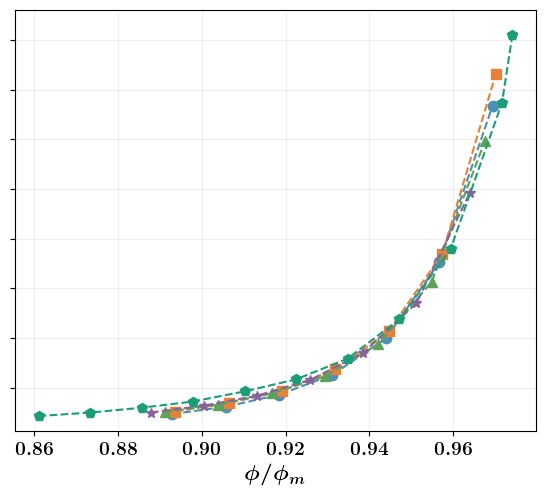

In [22]:
# To plot rheo parameter vs phim
# visc plot

# plotting functions

# Office Linux
#topDir = '/media/rahul/Rahul_2TB/high_bidispersity'
#fig_save_path = "/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/SOR_meeting/figures/"
#fig_save_path = "/home/rahul/Dropbox (City College)/CUNY/Research/Bidisperse Project/SOR_meeting/figures/"

#Mac
#topDir        = "/Volumes/Rahul_2TB/high_bidispersity/"
#fig_save_path = "/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/SOR_meeting/figures/"

# Home Linux
topDir        = '/media/rahul/Rahul_2TB/high_bidispersity'
fig_save_path = "/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/maron pierce/"
plt.clf()

phi  = [0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.792]
ar   = [1.0, 1.4, 1.8, 2.0, 4.0]
phim = [0.7839319645227314,0.783317545762567,0.7854135245320721,0.7884149253842823,0.813] #0.8181942616808251 #0.813
npp  = 1000
y    = 3 #viscosity=3 #pp=8

off     = 100 
numRuns = 4

phi_vals      = phi
arr           = ar
line_markers  = ['o', 's', '^', '*', 'p']
#cmap = matplotlib.colormaps['viridis_r'] #color scheme
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

plt.figure(figsize=(5.5,5))

for j, arj in enumerate(arr):
    params = []
    params_err = []
    phim_vals      = [i/phim[j] for i in phi]
    for i, phii in enumerate(phi_vals):
        dat    = []
        daterr = []
        phir   = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
        for l in range(numRuns):
            workDir = f'{topDir}/NP_1000/phi_{phir}/ar_{ar[j]}/Vr_0.5/run_{l+1}'
            if not os.path.exists(workDir):
                continue
            file_name = glob.glob(f'{workDir}/data_*.dat')[0]
            with open(f'{file_name}','r') as file:
                data_array = np.loadtxt(file) 
                data = data_array[:, y][off:]
                dat.append(np.mean(data))
                daterr.append(np.std(data))
        params.append(np.mean(dat) if len(dat) > 0 else np.nan)
        params_err.append(np.mean(daterr) if len(dat) > 0 else np.nan)
    
    #plt.errorbar(phim_vals, params, yerr=params_err, fmt='--o', label=r'$\delta = {:.1f}$'.format(arj), color=cmap((j+1)/len(arr)), capsize=2, linewidth=1.2, elinewidth=0.5)
    plt.plot(phim_vals, params, linestyle='--',marker=line_markers[j], label=r'$\delta = {:.1f}$'.format(arj), color=colors[j], linewidth=1.5, markersize=7.5)
        
plt.grid(which='Both', alpha=0.2)

#plt.title(labels[1][y], fontsize=18)
plt.xlabel(r'$\phi/\phi_m$', fontsize=16,fontstyle='italic')
#plt.ylabel(r'$\mathit{\eta_{r}}$', fontsize=20,fontstyle='italic')

#plt.xlim(.88,.979)
plt.ylim(30,2150)

#plt.yscale('log')
plt.xticks(fontsize=14)
#plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)  # Disable x ticks but keep grid
plt.yticks(fontsize=14)
plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=False) 
#plt.legend(loc='upper left', fontsize=15, labelspacing=1.5,borderpad=1.2, markerscale=1.2)
xlim = plt.gca().get_xlim()
print("Current x-axis limits:", xlim)
plt.tight_layout()

figsave=True
if figsave:
    figFormat=".svg"
    #plt.savefig(fig_save_path+'viscosity'+'_vs_phim_'+str(npp)+figFormat, bbox_inches="tight",dpi=500)
    plt.savefig(fig_save_path+'phim_4.0_'+str(phim[-1])+str(npp)+figFormat, bbox_inches="tight",dpi=500)

plt.show()